# Prepare
## Dataset loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
train_raw = pd.read_excel('/home/competition/data/data/ai_competition_train.xlsx')
test_raw = pd.read_excel('/home/competition/data/data/ai_competition_test.xlsx')

train = np.array(train_raw['flux'])
test = np.array(test_raw['flux'])

print(train.shape, test.shape)

2023-10-12 15:44:20.187788: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 15:44:20.189900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 15:44:20.231608: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 15:44:20.232434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 15:44:21.078802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

(5479,) (60,)


## Nan -> zero (Only train)

In [2]:
# NaN 값을 0.0으로 대체
nan_indices = np.isnan(train)
_mask = np.zeros(len(train))
train[nan_indices] = _mask[nan_indices]

# NaN 값을 대체한 결과 확인
print(train)
print(np.mean(train))
print("NaN 값의 개수:", np.sum(np.isnan(test)))


[ 94.8    96.93   97.71  ...   0.    128.634 143.651]
78.29537461215551
NaN 값의 개수: 0


## Cut zero (Only train)
- 인위적인 이동평균을 넣어주는 것은 오히려 악영향이라고 생각 > 끊어진 부분 강제로 이어붙임으로서 그것 또한 노이즈하고 생각하기

In [3]:
train_cut = train[train != 0]
print(train_cut.shape)
print(np.mean(train_cut))

(4228,)
101.46176856669818


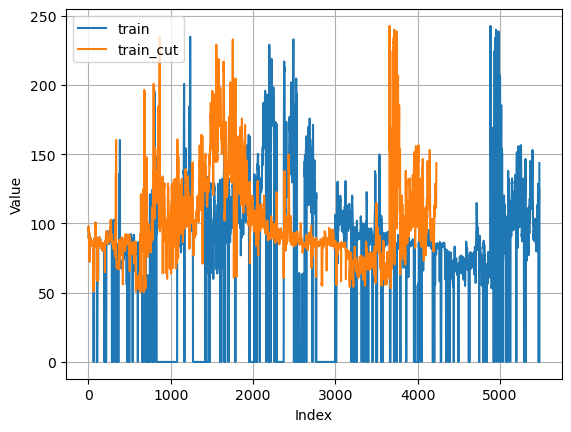

In [4]:
plt.figure()
plt.plot(train, label='train')
plt.plot(train_cut, label='train_cut')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Subtract Mean

In [5]:
train_cut_sub_mean = train_cut - np.mean(train_cut)
print(np.mean(train_cut_sub_mean), np.var(train_cut_sub_mean))

test_mean = np.mean(test)
test_sub_mean = test - test_mean
print(np.mean(test_sub_mean), np.var(test_sub_mean))


1.118583833779382e-14 926.6917847239334
1.4210854715202004e-14 234.5757282247222


## Make dataset

In [6]:
INPUT_DAYS = 60

train_x = np.empty([INPUT_DAYS, 1])
train_y = np.empty([1, 1])

print("x and y shape :", train_x.shape, train_y.shape)
for i in range(len(train_cut_sub_mean) - INPUT_DAYS - 1):
    train_x = np.concatenate(
        (train_x, train_cut_sub_mean[i:i+INPUT_DAYS, np.newaxis]), axis=1)
    train_y = np.concatenate(
        (train_y, train_cut_sub_mean[np.newaxis, i+INPUT_DAYS+1, np.newaxis]), axis=1)

print("x and y shape :", train_x.shape, train_y.shape)

train_x = train_x.T
train_y = train_y.T
print("x and y shape :", train_x.shape, train_y.shape)


x and y shape : (60, 1) (1, 1)
x and y shape : (60, 4168) (1, 4168)
x and y shape : (4168, 60) (4168, 1)


---

# Model

In [7]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, input_shape=(INPUT_DAYS, 1)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [8]:
loss_history = []
rmse_history = []

class RMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        rmse_history.append(tf.sqrt(logs['loss']))


class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])

rmse_callback = RMSECallback()
loss_callback = LossHistory()


In [9]:
model.fit(train_x, train_y, epochs=50, batch_size=256,
          callbacks=[rmse_callback, loss_callback])


Epoch 1/50
17/17 [==============================] - 3s 35ms/step - loss: 958.5591
Epoch 2/50
17/17 [==============================] - 1s 35ms/step - loss: 897.4602
Epoch 3/50
17/17 [==============================] - 1s 35ms/step - loss: 847.6465
Epoch 4/50
17/17 [==============================] - 1s 35ms/step - loss: 802.3714
Epoch 5/50
17/17 [==============================] - 1s 35ms/step - loss: 766.8616
Epoch 6/50
17/17 [==============================] - 1s 36ms/step - loss: 726.4786
Epoch 7/50
17/17 [==============================] - 1s 38ms/step - loss: 693.4426
Epoch 8/50
17/17 [==============================] - 1s 40ms/step - loss: 663.9305
Epoch 9/50
17/17 [==============================] - 1s 41ms/step - loss: 637.9152
Epoch 10/50
17/17 [==============================] - 1s 38ms/step - loss: 616.5615
Epoch 11/50
17/17 [==============================] - 1s 37ms/step - loss: 596.2874
Epoch 12/50
17/17 [==============================] - 1s 39ms/step - loss: 577.9076
Epoch 13/50
1

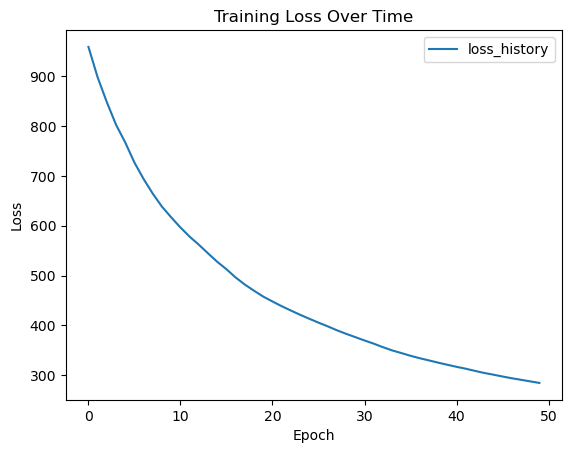

In [10]:

plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.legend(['loss_history', 'rmse_history'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


---

# Prediction

- input 60개로 61번째 예측
- 2번째 ~ 61번째로, 62번째 예측
- 90번째를 예측할 때 까지 반복하고, 61~90번째를 제출

In [11]:
final_result = test_sub_mean
print(final_result.shape)
for i in range(30):
    _single_output = model(
        final_result[np.newaxis, i:i+INPUT_DAYS, np.newaxis]).numpy()
    final_result = np.concatenate((final_result, _single_output[0]), axis=0)    


(60,)


## Subtract mean했던거 다시 더해주기

In [12]:
_summit = final_result[-30:]
print(np.mean(_summit))
_summit = _summit + test_mean
print(np.mean(_summit))
print(_summit.shape)
print(_summit)

-4.393260275324185
129.5887230580091
(30,)
[115.75600639 115.91932312 117.82540145 119.70098796 121.47827354
 123.42591587 125.72946277 128.4235045  131.49562183 134.54883018
 137.8604857  141.50951353 144.64911666 145.83342758 145.36791435
 144.1320869  141.94607463 137.82408228 131.46034875 124.43611637
 120.0417892  118.46841922 119.16308704 120.81903759 122.65499893
 124.35696426 126.36494079 129.45715061 134.46775323 142.54505649]


## output xlsx file 생성

In [13]:
import datetime

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# 주어진 벡터 데이터
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
        11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

# 데이터를 Pandas DataFrame으로 변환
df = pd.DataFrame({'date': data, 'flux': _summit})

# DataFrame을 엑셀 파일로 내보내기
file_name = f'/home/competition/data/final_results_review/output_{current_time}_{loss_history[-1]}.xlsx'
df.to_excel(file_name, index=False)

model_name = f'/home/competition/data/final_results_review/model_{current_time}_{loss_history[-1]}.h5'
model.save(model_name)


/home/competition/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
